#Visualize intermediate activations / convnet filters via GradientTape

In [0]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from six.moves import urllib

In [3]:
# Download the panda image
source = 'https://s3.eu-central-1.amazonaws.com/zooparc/assets/team_panda/yuanzi_300x300.jpg'
dest = 'panda.jpg'
urllib.request.urlretrieve(source, dest)

('panda.jpg', <httplib.HTTPMessage instance at 0x7f5386c46f38>)

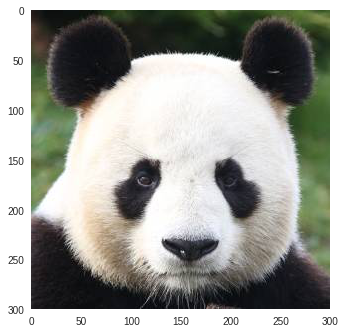

In [4]:
plt.imshow(plt.imread(dest))
plt.grid(False)

In [0]:
# Image preprocessing
img = image.load_img(dest, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [0]:
# Load the pre-trained VGG16 model
model = tf.keras.applications.VGG16(weights='imagenet')

In [7]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

('Predicted:', [(u'n02510455', u'giant_panda', 1.0), (u'n04399382', u'teddy', 4.9771533e-08), (u'n02133161', u'American_black_bear', 4.8543892e-08)])


The panda class was correctly predicted by the model.

## Intermediate Activations

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# Creates a model that will return the top 10 layers' outputs, given the model input:
layer_outputs = [layer.output for layer in model.layers[:10]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(x)

In [11]:
# first conv layer activation
first_conv_activation = activations[1]
print(first_conv_activation.shape)

(1, 224, 224, 64)


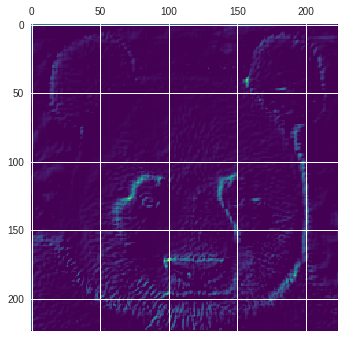

In [12]:
plt.matshow(first_conv_activation[0, :, :, 0], cmap='viridis')
plt.show()

This is the activation of the first channel of the first conv layer. Now let's visualize the activations of the first conv layer, the first pooling layer and the fifth conv layer.

In [0]:
def plot_activations(layer_idx, activations):
    layer_activation = activations[layer_idx][0]
    n_row = 8
    n_column = layer_activation.shape[-1]//n_row
    
    f, ax = plt.subplots(n_row, n_column)
    for i in range(n_row):
        for j in range(n_column):
            channel_image = layer_activation[:, :, i*n_column+j]
            # image post-processing for better visualization
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        
            ax[i, j].imshow(channel_image, cmap='viridis')
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    f.set_size_inches(n_column, n_row)
    plt.show()

###The first conv layer activations

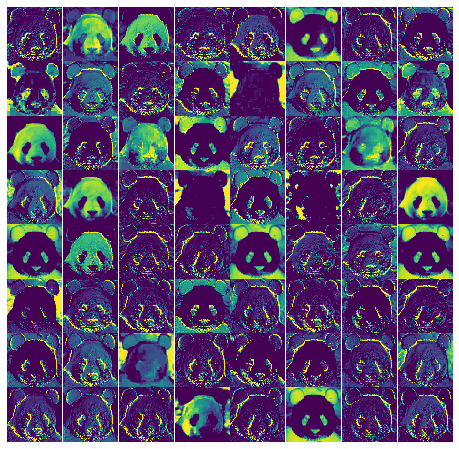

In [14]:
plot_activations(1, activations)

### The first pooling layer activations

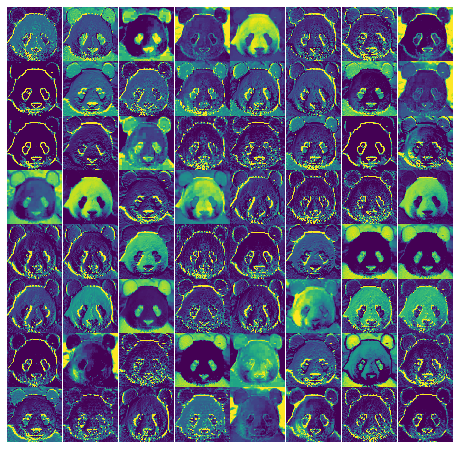

In [15]:
plot_activations(3, activations)

### The fifth conv layer activations

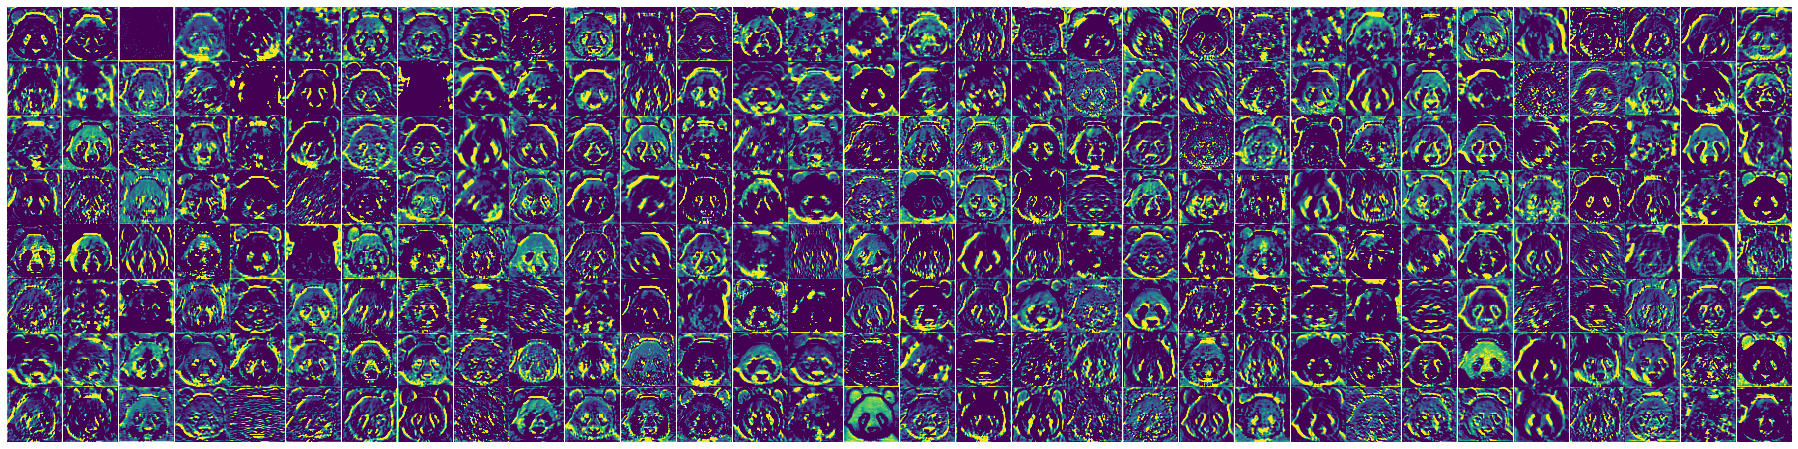

In [16]:
plot_activations(7, activations)

The activations become increasingly abstract and less visually interpretable for higher layers.

## Visualizing convnet filters

In [17]:
# Reload the VGG16 model without dense layers
model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 5s 0us/step


In [0]:
# Post-process the generated image tensor into a displayable image

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
# Generate the pattern corresponding to the conv layer filter
# GradientTape is used here

def generate_pattern(layer_name, filter_index, size=240):
    # Create a new model that will return the specific convolutional layer output, given the VGG input:
    new_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    # Create a gray image with some noise as input
    x = np.random.random((1, size, size, 3)) * 20 + 128.
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    x = tfe.Variable(x)
    
    step=1.
    for i in range(40):
        with tf.GradientTape() as tape:
            conv_layer_output = new_model(x)
            loss_value = tf.reduce_mean(conv_layer_output[:, :, :, filter_index])
        grads = tape.gradient(loss_value, x) # Compute the gradient of the input picture w.r.t. this loss
        grads /= (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5) # Normalize the gradient
        x.assign_add(grads*step) # Gradient ascent
     
    img = x[0].numpy()
    return deprocess_image(img)

Now let's visualize the first filter of block3_conv1 layer.

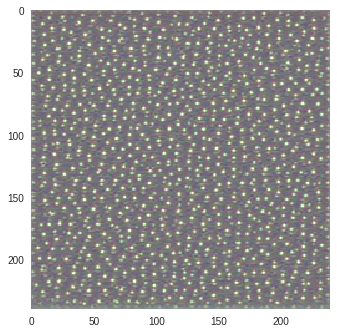

In [20]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.grid(False)

Now let's explore the block2_conv1 filters! It may take a long time so we only calculate and plot the first 64 filters.

In [0]:
def plot_filters(layer_name):
    # n_filters = model.get_layer(layer_name).output_shape[-1]
    n_filters = 64
    n_row = 8
    n_column = n_filters//n_row
    
    f, ax = plt.subplots(n_row, n_column)
    for i in range(n_row):
        for j in range(n_column):
            channel_image = generate_pattern(layer_name, i*n_column+j)
            print('{}/{} images generated!'.format(i*n_column+j+1, n_filters))        
            ax[i, j].imshow(channel_image)
            ax[i, j].axis('off')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    f.set_size_inches(n_column, n_row)
    plt.show()

1/64 images generated!
2/64 images generated!
3/64 images generated!
4/64 images generated!
5/64 images generated!
6/64 images generated!
7/64 images generated!
8/64 images generated!
9/64 images generated!
10/64 images generated!
11/64 images generated!
12/64 images generated!
13/64 images generated!
14/64 images generated!
15/64 images generated!
16/64 images generated!
17/64 images generated!
18/64 images generated!
19/64 images generated!
20/64 images generated!
21/64 images generated!
22/64 images generated!
23/64 images generated!
24/64 images generated!
25/64 images generated!
26/64 images generated!
27/64 images generated!
28/64 images generated!
29/64 images generated!
30/64 images generated!
31/64 images generated!
32/64 images generated!
33/64 images generated!
34/64 images generated!
35/64 images generated!
36/64 images generated!
37/64 images generated!
38/64 images generated!
39/64 images generated!
40/64 images generated!
41/64 images generated!
42/64 images generated!
4

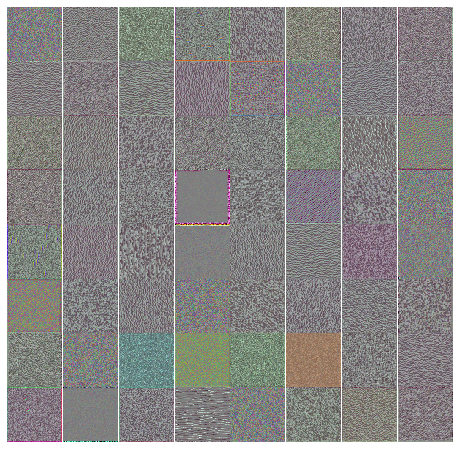

In [22]:
plot_filters('block2_conv1')

We can see that the filters from block2_conv1 encode simple textures made from combinations of edges and colors.